In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap


/rds/general/user/nk2622/home/pdkit-env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np

# Load extracted features per participant
features_df = pd.read_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv")

# Load metadata with UPDRS scores
meta_df = pd.read_csv("/rds/general/user/nk2622/home/final_metadata_PD_HC_trimmed_ON_OFF.csv")

# Print column names for manual validation
print("Feature columns:", features_df.columns.tolist())
print("Metadata columns:", meta_df.columns.tolist())


Feature columns: ['participant_id', 'tremor_amp', 'tremor_bandpower', 'entropy', 'sma', 'corr_xy', 'corr_xz', 'corr_yz', 'zcr_x', 'zcr_y', 'zcr_z']
Metadata columns: ['participant_id', 'cohort_code', 'cohort_group', 'ledd', 'sex', 'age', 'education', 'has_trimmed_csv', 'activity3_17_start_timestamp', 'activity3_17_end_timestamp', 'NHY', 'NHY_ON', 'updrs3_score', 'updrs3_score_on']


In [3]:
# Ensure participant_id is string in both for consistent merge
features_df['participant_id'] = features_df['participant_id'].astype(str)
meta_df['participant_id'] = meta_df['participant_id'].astype(str)

# Merge UPDRS Part III total score in OFF state
merged_df = features_df.merge(
    meta_df[['participant_id', 'updrs3_score', 'cohort_group']],
    on='participant_id',
    how='left'
)

# Drop rows with missing scores
merged_df = merged_df.dropna(subset=['updrs3_score'])

# Confirm shape and score range
print("Merged shape:", merged_df.shape)
print("UPDRS3 score distribution:\n", merged_df['updrs3_score'].describe())


Merged shape: (3310, 13)
UPDRS3 score distribution:
 count    3310.000000
mean       29.331420
std        16.725319
min         0.000000
25%        18.000000
50%        28.000000
75%        40.000000
max        75.000000
Name: updrs3_score, dtype: float64


In [4]:
# Define feature columns (already extracted tremor features)
feature_cols = ['tremor_amp', 'tremor_bandpower', 'entropy', 'sma']
target_col = 'updrs3_score'  # Total Part III score in OFF state

X = merged_df[feature_cols]
y = merged_df[target_col]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into train and test sets (stratify not needed for regression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}


In [7]:
# Train models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"{name} model fitted.")

# Evaluate models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} performance:")
    print(f" MAE:  {mae:.3f}")
    print(f" RMSE: {rmse:.3f}")
    print(f" R²:   {r2:.3f}")


Ridge model fitted.
Lasso model fitted.
Random Forest model fitted.
XGBoost model fitted.
SVR model fitted.

Ridge performance:
 MAE:  12.701
 RMSE: 15.937
 R²:   0.133

Lasso performance:
 MAE:  12.726
 RMSE: 15.946
 R²:   0.132

Random Forest performance:
 MAE:  8.072
 RMSE: 11.228
 R²:   0.570

XGBoost performance:
 MAE:  8.073
 RMSE: 11.229
 R²:   0.570

SVR performance:
 MAE:  10.519
 RMSE: 14.206
 R²:   0.311


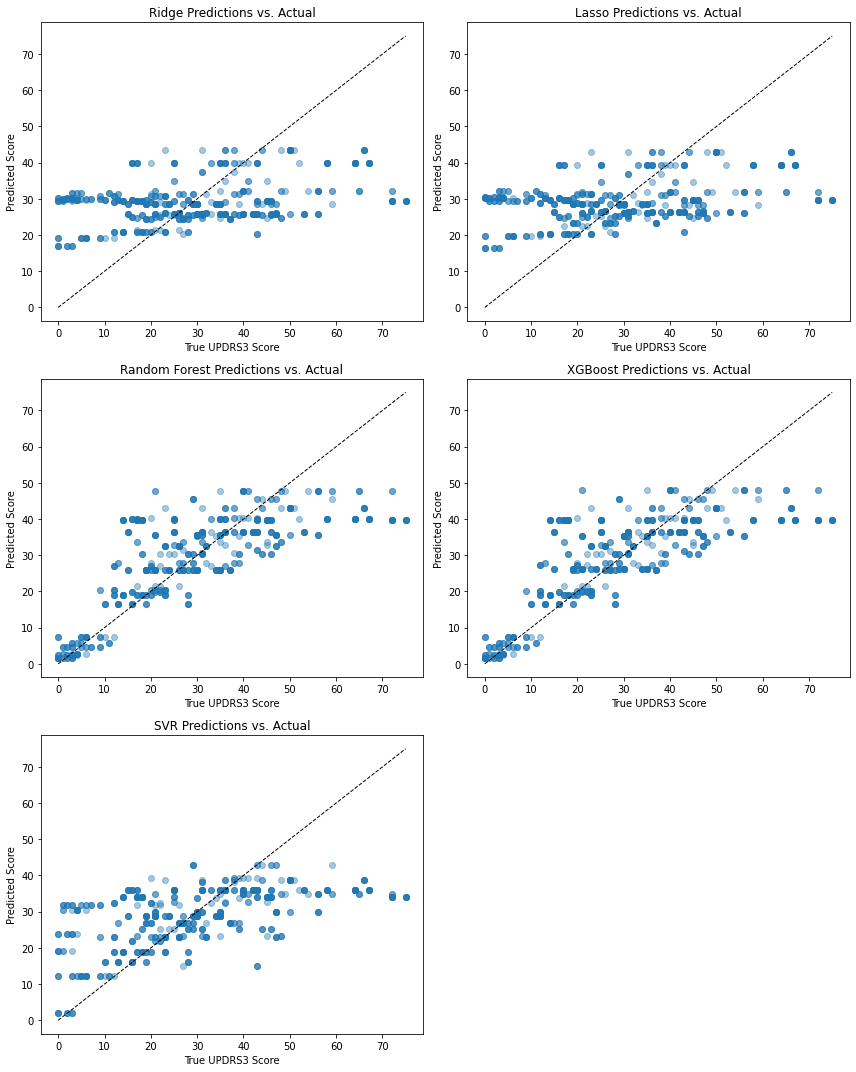

In [8]:
import matplotlib.pyplot as plt
import math

# Dynamically calculate grid size
n_models = len(models)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    axes[i].scatter(y_test, y_pred, alpha=0.4)
    axes[i].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    axes[i].set_title(f"{name} Predictions vs. Actual")
    axes[i].set_xlabel("True UPDRS3 Score")
    axes[i].set_ylabel("Predicted Score")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("updrs3_pred_vs_actual_grid_fixed.png", dpi=300)
plt.show()


In [9]:
import pandas as pd

rf = models["Random Forest"]
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)


            Feature  Importance
3               sma    0.658373
2           entropy    0.182715
0        tremor_amp    0.092311
1  tremor_bandpower    0.066601



Processing model: Ridge
Plotting coefficients for Ridge...


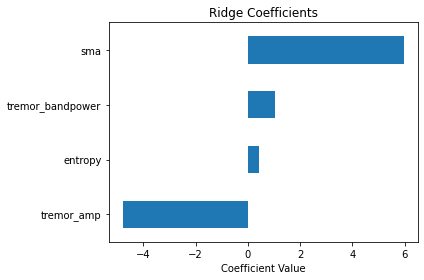

Saved: ridge_coefficients.png

Processing model: Lasso
Plotting coefficients for Lasso...


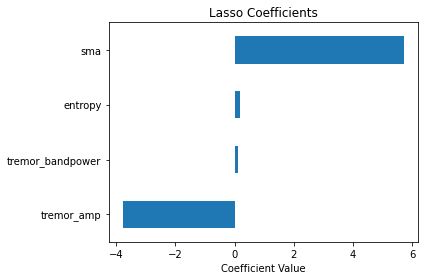

Saved: lasso_coefficients.png

Processing model: Random Forest
Generating SHAP summary for Random Forest using TreeExplainer...


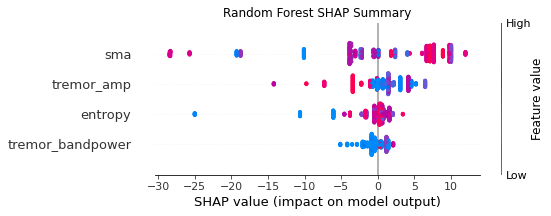

Saved: shap_summary_random_forest.png

Processing model: XGBoost
Generating SHAP summary for XGBoost using TreeExplainer...


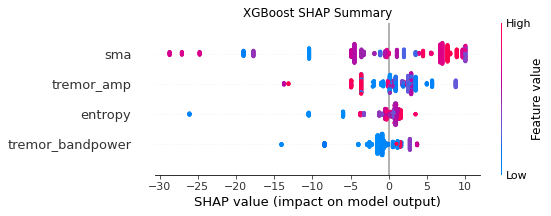

Saved: shap_summary_xgboost.png

Processing model: SVR
Skipping SHAP for unsupported model type: SVR


In [10]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress SHAP warnings

# Loop over models and generate appropriate explanation
for name, model in models.items():
    print(f"\nProcessing model: {name}")

    try:
        if name in ["Random Forest", "XGBoost"]:
            print(f"Generating SHAP summary for {name} using TreeExplainer...")

            # Special case for XGBoost: use booster directly
            if name == "XGBoost":
                explainer = shap.Explainer(model.get_booster())
                shap_values = explainer(X_test_scaled)
            else:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_test_scaled)

            # Plot SHAP summary (shown + saved)
            plt.figure()
            shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols, show=False)
            plt.title(f"{name} SHAP Summary")
            plt.tight_layout()
            save_path = f"shap_summary_{name.replace(' ', '_').lower()}.png"
            plt.savefig(save_path, dpi=300)
            plt.show()
            print(f"Saved: {save_path}")

        elif name in ["Ridge", "Lasso"]:
            print(f"Plotting coefficients for {name}...")
            coefs = pd.Series(model.coef_, index=feature_cols).sort_values()

            # Plot coefficient bar chart (shown + saved)
            plt.figure(figsize=(6, 4))
            coefs.plot(kind='barh')
            plt.title(f"{name} Coefficients")
            plt.xlabel("Coefficient Value")
            plt.tight_layout()
            save_path = f"{name.lower()}_coefficients.png"
            plt.savefig(save_path, dpi=300)
            plt.show()
            print(f"Saved: {save_path}")

        else:
            print(f"Skipping SHAP for unsupported model type: {name}")

    except Exception as e:
        print(f" Failed to explain {name}: {e}")


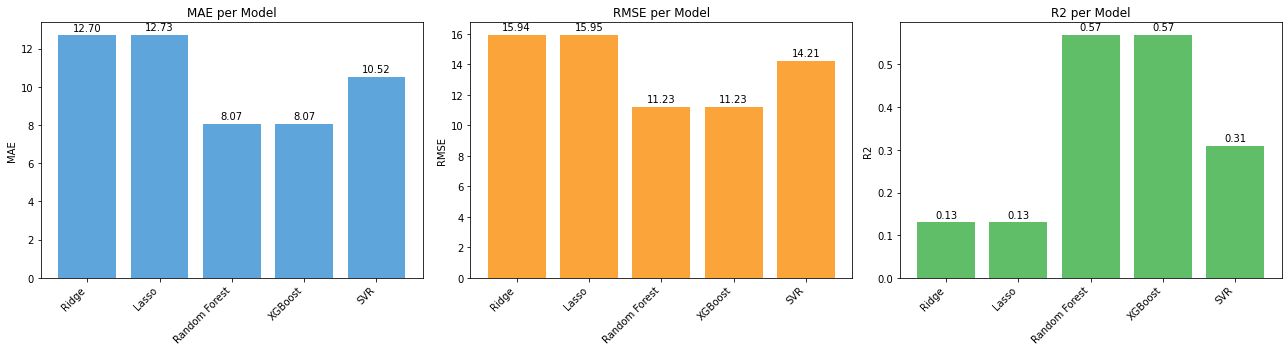

In [12]:
import pandas as pd

# Replace these with your actual model results
metrics_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Random Forest', 'XGBoost', 'SVR'],
    'MAE': [12.70, 12.73, 8.07, 8.07, 10.52],
    'RMSE': [15.94, 15.95, 11.23, 11.23, 14.21],
    'R2': [0.13, 0.13, 0.57, 0.57, 0.31]
}).set_index('Model')

import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ['MAE', 'RMSE', 'R2']
colors = ['#5DA5DA', '#FAA43A', '#60BD68']  # Optional custom color palette

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.bar(metrics_df.index, metrics_df[metric], color=colors[i])
    ax.set_title(f"{metric} per Model")
    ax.set_ylabel(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')

    # Annotate values
    for j, value in enumerate(metrics_df[metric]):
        ax.text(j, value + 0.01 * max(metrics_df[metric]), f"{value:.2f}",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("model_metrics_barplot_fixed.png", dpi=300)
plt.show()


In [13]:
# Add severity bin column based on quartiles
merged_df['severity_bin'] = pd.qcut(merged_df['updrs3_score'], 4, 
                                     labels=['Mild', 'Moderate', 'Severe', 'Very Severe'])


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Container to hold performance metrics per model per bin
stratified_metrics = []

# Loop over bins
for bin_label in merged_df['severity_bin'].unique():
    print(f"\nEvaluating for bin: {bin_label}")
    
    bin_subset = merged_df[merged_df['severity_bin'] == bin_label]
    X_bin = scaler.transform(bin_subset[feature_cols])  # scale features
    y_bin = bin_subset['updrs3_score']
    
    for model_name, model in models.items():
        y_pred = model.predict(X_bin)
        
        mae = mean_absolute_error(y_bin, y_pred)
        rmse = np.sqrt(mean_squared_error(y_bin, y_pred))
        r2 = r2_score(y_bin, y_pred)

        print(f"{model_name} — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
        
        stratified_metrics.append({
            'Model': model_name,
            'Severity Bin': bin_label,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })



Evaluating for bin: Moderate
Ridge — MAE: 5.49, RMSE: 7.03, R²: -4.80
Lasso — MAE: 5.63, RMSE: 7.05, R²: -4.83
Random Forest — MAE: 6.42, RMSE: 8.56, R²: -7.58
XGBoost — MAE: 6.45, RMSE: 8.59, R²: -7.64
SVR — MAE: 5.68, RMSE: 7.30, R²: -5.25

Evaluating for bin: Severe
Ridge — MAE: 6.15, RMSE: 7.14, R²: -3.50
Lasso — MAE: 5.93, RMSE: 6.95, R²: -3.26
Random Forest — MAE: 5.01, RMSE: 6.14, R²: -2.33
XGBoost — MAE: 5.01, RMSE: 6.16, R²: -2.35
SVR — MAE: 4.06, RMSE: 5.48, R²: -1.66

Evaluating for bin: Very Severe
Ridge — MAE: 19.32, RMSE: 22.00, R²: -4.35
Lasso — MAE: 19.35, RMSE: 21.95, R²: -4.33
Random Forest — MAE: 11.93, RMSE: 15.09, R²: -1.52
XGBoost — MAE: 11.89, RMSE: 15.07, R²: -1.51
SVR — MAE: 16.97, RMSE: 19.89, R²: -3.37

Evaluating for bin: Mild
Ridge — MAE: 17.62, RMSE: 19.29, R²: -8.35
Lasso — MAE: 17.74, RMSE: 19.42, R²: -8.48
Random Forest — MAE: 7.36, RMSE: 11.12, R²: -2.11
XGBoost — MAE: 7.36, RMSE: 11.13, R²: -2.11
SVR — MAE: 13.02, RMSE: 16.07, R²: -5.49


In [15]:
# Create a DataFrame from results
stratified_metrics_df = pd.DataFrame(stratified_metrics)


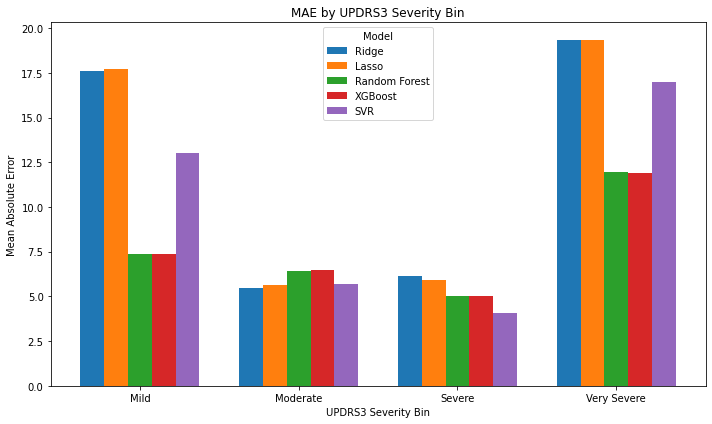

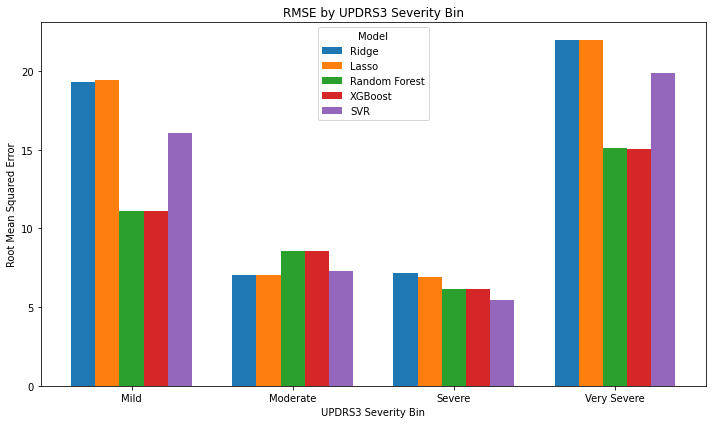

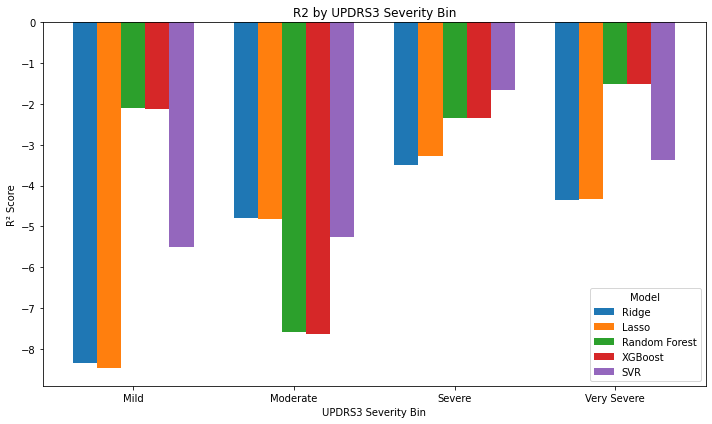

In [16]:
import matplotlib.pyplot as plt

# Define metric names and y-axis labels
metrics = ['MAE', 'RMSE', 'R2']
y_labels = {
    'MAE': 'Mean Absolute Error',
    'RMSE': 'Root Mean Squared Error',
    'R2': 'R² Score'
}

# Define severity bin order
severity_bins = ['Mild', 'Moderate', 'Severe', 'Very Severe']
models_list = stratified_metrics_df['Model'].unique()

# Create bar plots for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    width = 0.15  # width of each bar
    x = np.arange(len(severity_bins))  # positions for each bin

    # Plot bars for each model
    for i, model in enumerate(models_list):
        model_data = stratified_metrics_df[stratified_metrics_df['Model'] == model]
        model_data = model_data.set_index('Severity Bin').reindex(severity_bins)
        values = model_data[metric].values

        # Plot with offset for each model
        plt.bar(x + i * width, values, width=width, label=model)

    # Format plot
    plt.xlabel('UPDRS3 Severity Bin')
    plt.ylabel(y_labels[metric])
    plt.title(f'{metric} by UPDRS3 Severity Bin')
    plt.xticks(x + width * (len(models_list) - 1) / 2, severity_bins)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_by_bin.png", dpi=300)
    plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(y_true, y_pred, title='Bland-Altman Plot'):
    diff = y_true - y_pred
    mean = (y_true + y_pred) / 2

    mean_diff = np.mean(diff)
    sd_diff = np.std(diff)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean, diff, alpha=0.4)
    plt.axhline(mean_diff, color='gray', linestyle='--', label='Mean Diff')
    plt.axhline(mean_diff + 1.96 * sd_diff, color='red', linestyle='--', label='±1.96 SD')
    plt.axhline(mean_diff - 1.96 * sd_diff, color='red', linestyle='--')
    plt.xlabel('Mean of True & Predicted UPDRS3')
    plt.ylabel('Difference (True - Predicted)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


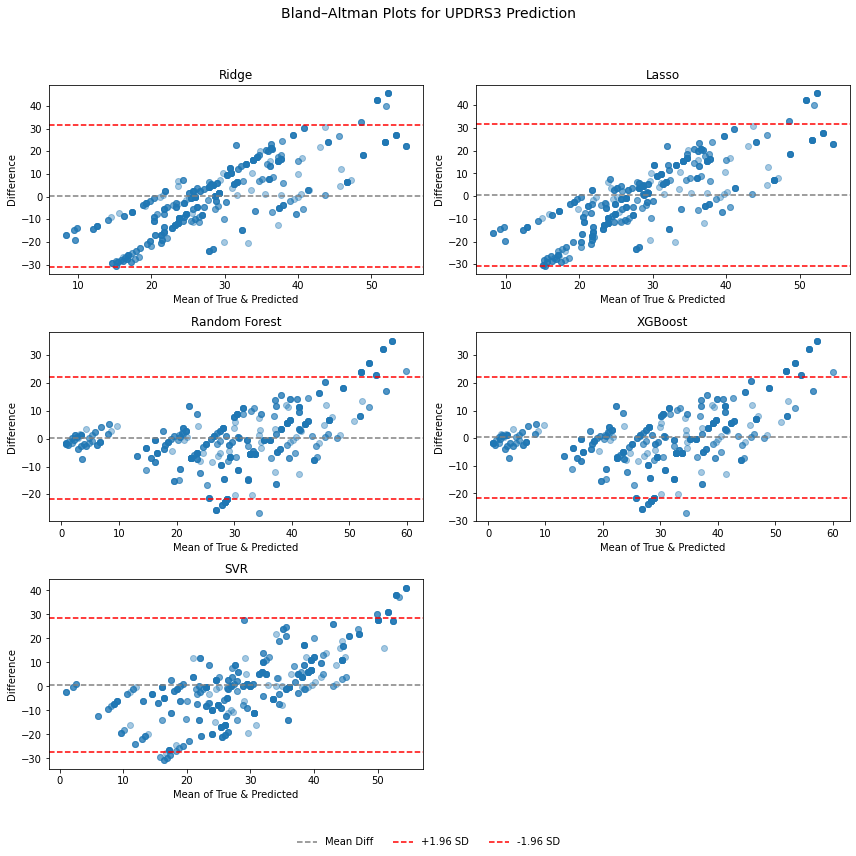

Saved: bland_altman_grid_shared_legend.png


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare layout
n_models = len(models)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

# Store one sample legend handle set
legend_handles = None

for idx, (name, model) in enumerate(models.items()):
    try:
        y_pred = model.predict(X_test_scaled)
        diff = y_test - y_pred
        mean = (y_test + y_pred) / 2
        mean_diff = np.mean(diff)
        sd_diff = np.std(diff)

        ax = axes[idx]
        ax.scatter(mean, diff, alpha=0.4)
        h1 = ax.axhline(mean_diff, color='gray', linestyle='--', label='Mean Diff')
        h2 = ax.axhline(mean_diff + 1.96 * sd_diff, color='red', linestyle='--', label='+1.96 SD')
        h3 = ax.axhline(mean_diff - 1.96 * sd_diff, color='red', linestyle='--', label='-1.96 SD')

        ax.set_title(name)
        ax.set_xlabel("Mean of True & Predicted")
        ax.set_ylabel("Difference")

        # Save legend handles (only once)
        if legend_handles is None:
            legend_handles = [h1, h2, h3]

    except Exception as e:
        print(f"Failed for model {name}: {e}")
        axes[idx].set_visible(False)

# Hide any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Add global legend below the plots
fig.legend(handles=legend_handles, loc='lower center', ncol=3, frameon=False)
fig.suptitle("Bland–Altman Plots for UPDRS3 Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space for legend and title
plt.savefig("bland_altman_grid_shared_legend.png", dpi=300)
plt.show()
print("Saved: bland_altman_grid_shared_legend.png")


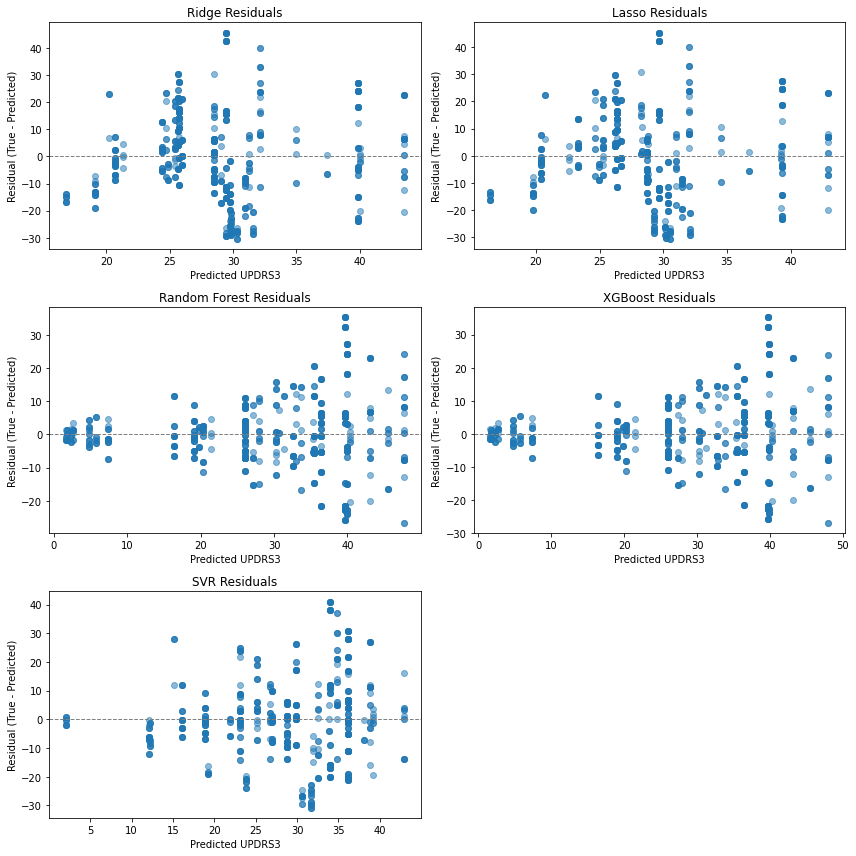

Saved: residuals_grid.png


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Setup for residual grid
n_models = len(models)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    try:
        y_pred = model.predict(X_test_scaled)
        residuals = y_test - y_pred

        ax = axes[i]
        ax.scatter(y_pred, residuals, alpha=0.5)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_title(f'{name} Residuals')
        ax.set_xlabel("Predicted UPDRS3")
        ax.set_ylabel("Residual (True - Predicted)")

    except Exception as e:
        print(f"Failed for model {name}: {e}")
        axes[i].set_visible(False)

# Hide any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("residuals_grid.png", dpi=300)
plt.show()
print("Saved: residuals_grid.png")


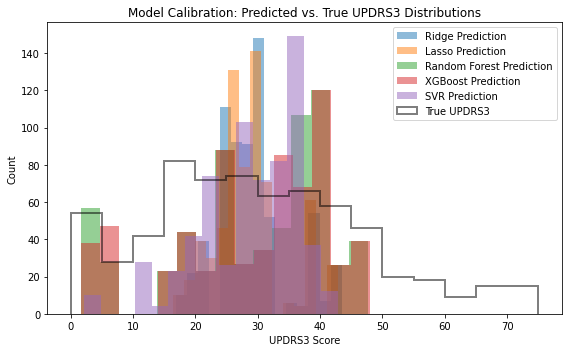

Saved: calibration_histograms.png


In [20]:
# Combine all predicted values
plt.figure(figsize=(8, 5))

for name, model in models.items():
    try:
        y_pred = model.predict(X_test_scaled)
        plt.hist(y_pred, bins=15, alpha=0.5, label=f'{name} Prediction')
    except Exception as e:
        print(f"Failed for model {name}: {e}")

# Plot true distribution
plt.hist(y_test, bins=15, alpha=0.5, label='True UPDRS3', color='black', histtype='step', linewidth=2)

plt.title("Model Calibration: Predicted vs. True UPDRS3 Distributions")
plt.xlabel("UPDRS3 Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("calibration_histograms.png", dpi=300)
plt.show()
print("Saved: calibration_histograms.png")


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Add severity bins to your merged dataframe (if not already added)
merged_df['severity_bin'] = pd.qcut(
    merged_df['updrs3_score'], 
    q=4, 
    labels=['Mild', 'Moderate', 'Severe', 'Very Severe']
)

# Container to collect correlation results
correlation_results = []

# Loop through severity bins
for bin_label in merged_df['severity_bin'].unique():
    bin_subset = merged_df[merged_df['severity_bin'] == bin_label]
    X_bin = scaler.transform(bin_subset[feature_cols])
    y_true = bin_subset['updrs3_score'].values

    for model_name, model in models.items():
        try:
            y_pred = model.predict(X_bin)

            # Compute Pearson and Spearman correlations
            pearson_corr, _ = pearsonr(y_true, y_pred)
            spearman_corr, _ = spearmanr(y_true, y_pred)

            correlation_results.append({
                'Model': model_name,
                'Severity Bin': bin_label,
                'Pearson R': pearson_corr,
                'Spearman R': spearman_corr
            })
        except Exception as e:
            print(f"Failed for model {model_name} in bin {bin_label}: {e}")

# Create a DataFrame of results
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df)


            Model Severity Bin  Pearson R  Spearman R
0           Ridge     Moderate  -0.006897   -0.002799
1           Lasso     Moderate  -0.014415   -0.005482
2   Random Forest     Moderate   0.097703    0.126771
3         XGBoost     Moderate   0.096739    0.126771
4             SVR     Moderate  -0.033517   -0.061175
5           Ridge       Severe   0.252799    0.262741
6           Lasso       Severe   0.246016    0.250594
7   Random Forest       Severe   0.288366    0.299545
8         XGBoost       Severe   0.289824    0.299977
9             SVR       Severe   0.330246    0.315378
10          Ridge  Very Severe   0.156678    0.194815
11          Lasso  Very Severe   0.157910    0.214463
12  Random Forest  Very Severe   0.191166    0.195401
13        XGBoost  Very Severe   0.189854    0.195401
14            SVR  Very Severe   0.057358    0.003751
15          Ridge         Mild   0.180295    0.028787
16          Lasso         Mild   0.172369    0.062851
17  Random Forest         Mi

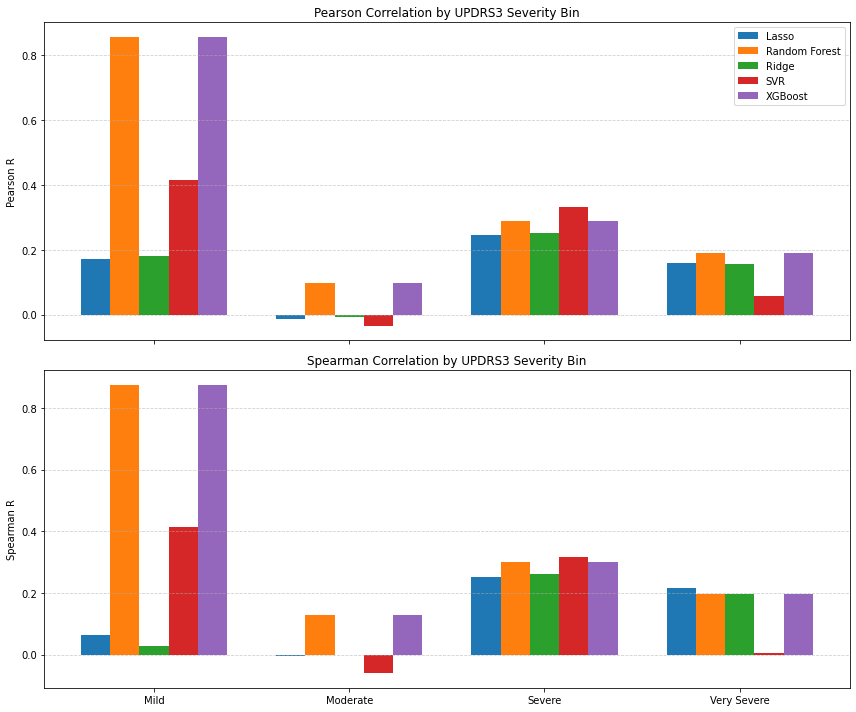

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Pivot tables for plotting
pivot_pearson = correlation_df.pivot(index='Severity Bin', columns='Model', values='Pearson R')
pivot_spearman = correlation_df.pivot(index='Severity Bin', columns='Model', values='Spearman R')

# Sort bins in correct order
severity_order = ['Mild', 'Moderate', 'Severe', 'Very Severe']
pivot_pearson = pivot_pearson.loc[severity_order]
pivot_spearman = pivot_spearman.loc[severity_order]

# Plotting settings
x = np.arange(len(severity_order))  # position of bars
bar_width = 0.15
model_names = pivot_pearson.columns.tolist()
n_models = len(model_names)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot Pearson R ---
for i, model in enumerate(model_names):
    axes[0].bar(
        x + i * bar_width,
        pivot_pearson[model],
        width=bar_width,
        label=model
    )
axes[0].set_ylabel("Pearson R")
axes[0].set_title("Pearson Correlation by UPDRS3 Severity Bin")
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# --- Plot Spearman R ---
for i, model in enumerate(model_names):
    axes[1].bar(
        x + i * bar_width,
        pivot_spearman[model],
        width=bar_width,
        label=model
    )
axes[1].set_ylabel("Spearman R")
axes[1].set_title("Spearman Correlation by UPDRS3 Severity Bin")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# X-axis labels
xtick_positions = x + bar_width * (n_models - 1) / 2
axes[1].set_xticks(xtick_positions)
axes[1].set_xticklabels(severity_order)

plt.tight_layout()
plt.savefig("correlation_by_severity_barplot.png", dpi=300)
plt.show()


In [23]:
errors = {
    model_name: np.abs(y_test - model.predict(X_test_scaled))
    for model_name, model in models.items()
}


In [24]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(errors['XGBoost'], errors['SVR'])
print(f"XGBoost vs SVR → t = {t_stat:.3f}, p = {p_val:.4f}")


XGBoost vs SVR → t = -8.716, p = 0.0000


In [25]:
from scipy.stats import wilcoxon

stat, p_val = wilcoxon(errors['XGBoost'], errors['SVR'])
print(f"XGBoost vs SVR (Wilcoxon) → stat = {stat}, p = {p_val:.4f}")


XGBoost vs SVR (Wilcoxon) → stat = 76146.5, p = 0.0000


In [26]:
from itertools import combinations
from scipy.stats import wilcoxon

results = []

for model1, model2 in combinations(errors.keys(), 2):
    stat, p = wilcoxon(errors[model1], errors[model2])
    results.append({
        "Model A": model1,
        "Model B": model2,
        "Wilcoxon p-value": p
    })


In [27]:
results_df = pd.DataFrame(results)
print(results_df)


         Model A        Model B  Wilcoxon p-value
0          Ridge          Lasso      3.625316e-01
1          Ridge  Random Forest      2.436280e-30
2          Ridge        XGBoost      4.921699e-30
3          Ridge            SVR      2.388694e-15
4          Lasso  Random Forest      9.622831e-31
5          Lasso        XGBoost      1.325398e-30
6          Lasso            SVR      3.457931e-15
7  Random Forest        XGBoost      7.668191e-01
8  Random Forest            SVR      4.440287e-12
9        XGBoost            SVR      8.815101e-12


In [28]:
from statsmodels.stats.multitest import multipletests

# Extract p-values
p_values = results_df['Wilcoxon p-value'].values
rejected, corrected_pvals, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Add to table
results_df['Bonferroni p'] = corrected_pvals
results_df['Significant'] = rejected


In [29]:
errors = {
    model_name: np.abs(y_test - model.predict(X_test_scaled))
    for model_name, model in models.items()
}


In [30]:
from itertools import combinations
from scipy.stats import wilcoxon


In [31]:
results = []

for model1, model2 in combinations(errors.keys(), 2):
    stat, p = wilcoxon(errors[model1], errors[model2])
    results.append({
        "Model A": model1,
        "Model B": model2,
        "Wilcoxon p-value": p
    })


In [32]:
results_df = pd.DataFrame(results)
print(results_df)


         Model A        Model B  Wilcoxon p-value
0          Ridge          Lasso      3.625316e-01
1          Ridge  Random Forest      2.436280e-30
2          Ridge        XGBoost      4.921699e-30
3          Ridge            SVR      2.388694e-15
4          Lasso  Random Forest      9.622831e-31
5          Lasso        XGBoost      1.325398e-30
6          Lasso            SVR      3.457931e-15
7  Random Forest        XGBoost      7.668191e-01
8  Random Forest            SVR      4.440287e-12
9        XGBoost            SVR      8.815101e-12
